<a href="https://colab.research.google.com/github/Anonymous143w/TP/blob/main/Time%20Series%20Prediction%20(Reliance).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.9 MB/s eta 0:00:00


In [3]:
!python -m pip install prophet

In [4]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import datetime
from pandas import Series
import statsmodels.api as sm

#Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
sns.set_style("whitegrid")
%matplotlib inline
import altair as alt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Timeseries model libraries
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from prophet import Prophet

#Performance metric libraries
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

In [8]:
reliance_raw=pd.read_csv("/content/RELIANCE.csv")

## print shape of dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(reliance_raw.shape))
print (reliance_raw.info())

The shape of the  data is (row, column):(5306, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4792 non-null   float64
 14  %Deliverble         4792 non-null   float64
dtypes: f

In [9]:
reliance_raw.head()

Date    Symbol Series  Prev Close    Open    High     Low    Last  \
0  2000-01-03  RELIANCE     EQ      233.05  237.50  251.70  237.50  251.70   
1  2000-01-04  RELIANCE     EQ      251.70  258.40  271.85  251.30  271.85   
2  2000-01-05  RELIANCE     EQ      271.85  256.65  287.90  256.65  286.75   
3  2000-01-06  RELIANCE     EQ      282.50  289.00  300.70  289.00  293.50   
4  2000-01-07  RELIANCE     EQ      294.35  295.00  317.90  293.00  314.50   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  251.70  249.37   4456424  1.111319e+14     NaN                 NaN   
1  271.85  263.52   9487878  2.500222e+14     NaN                 NaN   
2  282.50  274.79  26833684  7.373697e+14     NaN                 NaN   
3  294.35  295.45  15682286  4.633254e+14     NaN                 NaN   
4  314.55  308.91  19870977  6.138388e+14     NaN                 NaN   

   %Deliverble  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [10]:
reliance_raw.dtypes

Date                   object
Symbol                 object
Series                 object
Prev Close            float64
Open                  float64
High                  float64
Low                   float64
Last                  float64
Close                 float64
VWAP                  float64
Volume                  int64
Turnover              float64
Trades                float64
Deliverable Volume    float64
%Deliverble           float64
dtype: object

In [11]:
reliance_raw.describe()

Prev Close         Open         High          Low         Last  \
count  5306.000000  5306.000000  5306.000000  5306.000000  5306.000000   
mean   1010.984866  1012.602375  1026.823803   996.886977  1011.157143   
std     570.987079   572.575893   581.986757   560.703328   570.938608   
min     203.200000   205.500000   219.500000   197.150000   203.300000   
25%     572.137500   572.925000   582.950000   564.237500   572.062500   
50%     937.950000   939.000000   950.075000   927.550000   939.025000   
75%    1247.387500  1247.675000  1267.350000  1227.450000  1248.287500   
max    3220.850000  3298.000000  3298.000000  3141.300000  3223.000000   

             Close         VWAP        Volume      Turnover        Trades  \
count  5306.000000  5306.000000  5.306000e+03  5.306000e+03  2.456000e+03   
mean   1011.316839  1011.937409  5.583028e+06  6.076715e+14  1.452306e+05   
std     571.046753   571.222520  4.983793e+06  8.369739e+14  1.297557e+05   
min     203.200000   212.290000  5.282000e+04  4.295543e+12  2.991000e+03   
25%     572.512500   573.190000  2.836454e+06  2.203354e+14  7.215900e+04   
50%     938.275000   939.785000  4.213432e+06  3.662999e+14  1.021435e+05   
75%    1248.275000  1247.375000  6.602604e+06  6.656490e+14  1.686702e+05   
max    3220.850000  3197.750000  6.523089e+07  1.473434e+16  1.428490e+06   

       Deliverable Volume  %Deliverble  
count        4.792000e+03  4792.000000  
mean         2.280885e+06     0.435039  
std          1.882665e+06     0.144722  
min          2.909700e+04     0.076300  
25%          1.194524e+06     0.323325  
50%          1.810434e+06     0.449450  
75%          2.752935e+06     0.544300  
max          3.495888e+07     0.978300

In [12]:
reliance_analysis=reliance_raw.copy()

#Coverting date column to datetime data type
reliance_analysis['Date'] = reliance_analysis['Date'].apply(pd.to_datetime)

#Extracting Month, Week, Day,Day of week
reliance_analysis["Month"] = reliance_analysis.Date.dt.month
reliance_analysis["Week"] = reliance_analysis.Date.dt.isocalendar().week
reliance_analysis["Day"] = reliance_analysis.Date.dt.day
reliance_analysis["Day of week"] = reliance_analysis.Date.dt.dayofweek


#Setting date column as index
reliance_analysis.set_index("Date", drop=False, inplace=True)
reliance_analysis.iloc[:,15:19].head()

Month  Week  Day  Day of week
Date                                     
2000-01-03      1     1    3            0
2000-01-04      1     1    4            1
2000-01-05      1     1    5            2
2000-01-06      1     1    6            3
2000-01-07      1     1    7            4

In [13]:
#Imputing null values with mean for numerical columns only
numeric_columns = reliance_analysis.select_dtypes(include=['number']).columns
reliance_analysis[numeric_columns] = reliance_analysis[numeric_columns].fillna(reliance_analysis[numeric_columns].mean())

#Checking for null values
reliance_analysis.isnull().sum()

Date                  0
Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
Month                 0
Week                  0
Day                   0
Day of week           0
dtype: int64

# **Distrubution of stock measures**

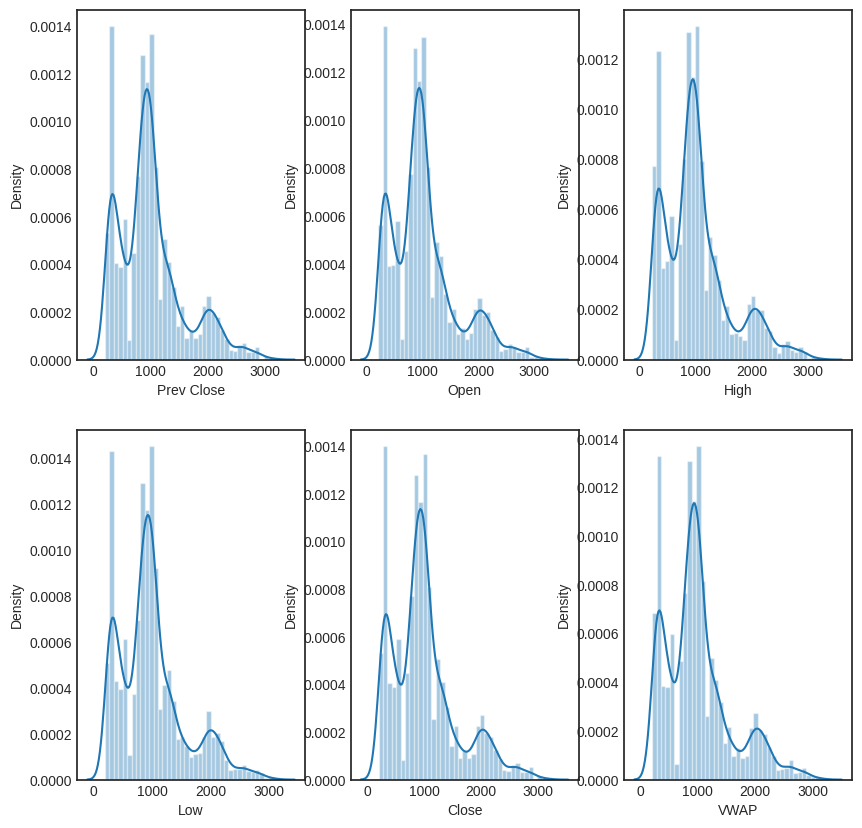

In [14]:
#Size and style of the plot
plt.figure(figsize = (15, 7))
plt.style.use('seaborn-white')

#Subplots of distplot
plt.subplot(231)
sns.distplot(reliance_analysis['Prev Close'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(232)
sns.distplot(reliance_analysis['Open'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(233)
sns.distplot(reliance_analysis['High'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(234)
sns.distplot(reliance_analysis['Low'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(235)
sns.distplot(reliance_analysis['Close'])
fig = plt.gcf()
fig.set_size_inches(10,10)

plt.subplot(236)
sns.distplot(reliance_analysis['VWAP'])
fig = plt.gcf()
fig.set_size_inches(10,10)


# **VWAP over time**

In [15]:
# Install and upgrade plotly if necessary
!pip install plotly --upgrade

import plotly.express as px
import plotly.io as pio

# Ensure that the plotly renderer is set for Google Colab
pio.renderers.default = 'colab'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 72.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [16]:
# Assuming reliance_analysis is already defined and properly loaded
fig = px.line(reliance_analysis, x='Date', y='VWAP', title='VWAP over Years (Use Rangeslider to slide over time)')
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
fig.show()


# **Open, Close, High, Low**

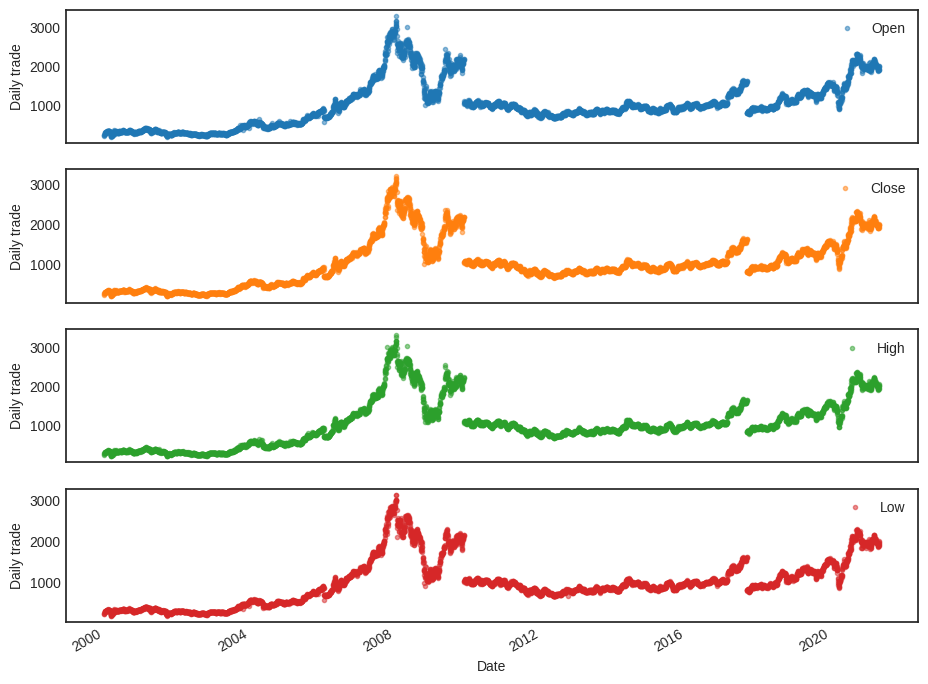

In [17]:
cols_plot = ['Open', 'Close', 'High','Low']
axes = reliance_analysis[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily trade')

# **Volume of share over the years**

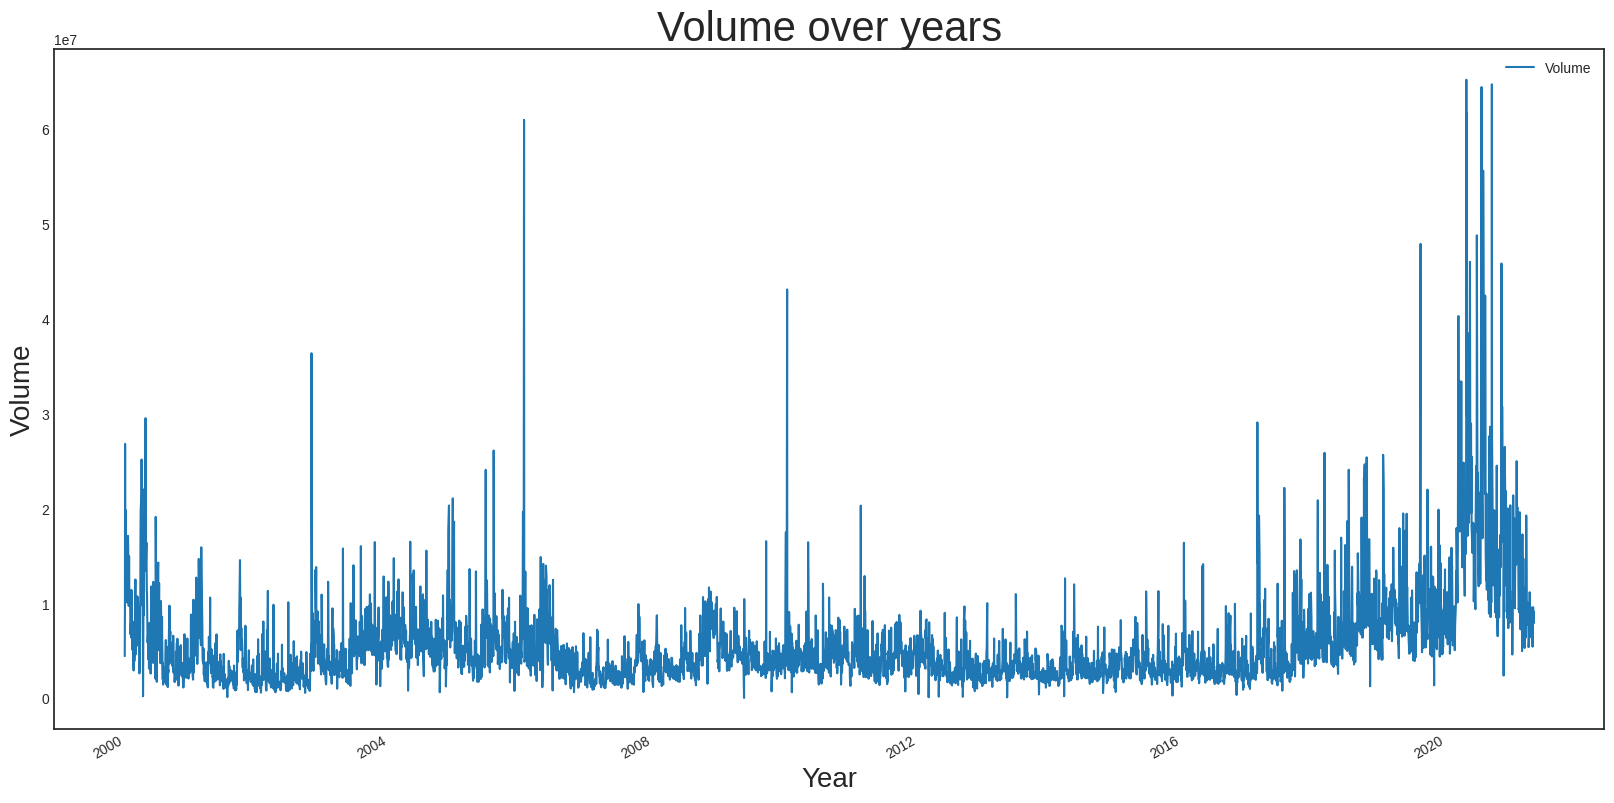

In [18]:
ax=reliance_analysis[['Volume']].plot(stacked=True)
ax.set_title('Volume over years',fontsize= 30)
ax.set_xlabel('Year',fontsize = 20)
ax.set_ylabel('Volume',fontsize = 20)
plt.show()

# **Open Vs Close over time**

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=reliance_analysis['Date'],
         y=reliance_analysis['Open'],
         name='Open',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=reliance_analysis['Date'],
         y=reliance_analysis['Close'],
         name='Close',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)


fig.update_layout(title_text='Open Vs Close',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

# **Moving average analysis**

In [20]:
reliance_lag=reliance_analysis.copy()
#Reset index
reliance_lag.reset_index(drop=True, inplace=True)
#Creating lag features
lag_features = ["High", "Low", "Volume", "VWAP"]

# Taking the number of days in window
window1 = 3
window2 = 7
window3 = 30

#Rolling mean
df_rolled_3d = reliance_lag[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = reliance_lag[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = reliance_lag[lag_features].rolling(window=window3, min_periods=0)

#Moving average
df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float32)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float32)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float32)

#Standard deviation
df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float32)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float32)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float32)

# Adding the features to the dataframe
for feature in lag_features:
    reliance_lag[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    reliance_lag[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    reliance_lag[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    reliance_lag[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    reliance_lag[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    reliance_lag[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

# Drop non-numeric columns before calculating the mean
numeric_reliance_lag = reliance_lag.select_dtypes(include='number')
reliance_lag.fillna(numeric_reliance_lag.mean(), inplace=True)

#Setting Date as index
reliance_lag.set_index("Date", drop=False, inplace=True)
reliance_lag.head()

Date    Symbol Series  Prev Close    Open    High     Low  \
Date                                                                         
2000-01-03 2000-01-03  RELIANCE     EQ      233.05  237.50  251.70  237.50   
2000-01-04 2000-01-04  RELIANCE     EQ      251.70  258.40  271.85  251.30   
2000-01-05 2000-01-05  RELIANCE     EQ      271.85  256.65  287.90  256.65   
2000-01-06 2000-01-06  RELIANCE     EQ      282.50  289.00  300.70  289.00   
2000-01-07 2000-01-07  RELIANCE     EQ      294.35  295.00  317.90  293.00   

              Last   Close    VWAP  ...  Volume_mean_lag30  Volume_std_lag3  \
Date                                ...                                       
2000-01-03  251.70  251.70  249.37  ...          5595386.0       1671437.75   
2000-01-04  271.85  271.85  263.52  ...          4456424.0       1671437.75   
2000-01-05  286.75  282.50  274.79  ...          6972151.0       3557775.25   
2000-01-06  293.50  294.35  295.45  ...         13592662.0      11739778.00   
2000-01-07  314.50  314.55  308.91  ...         14115068.0       8790159.00   

            Volume_std_lag7  Volume_std_lag30  VWAP_mean_lag3  VWAP_mean_lag7  \
Date                                                                            
2000-01-03       2045707.25        2583829.50     1011.416748     1010.776978   
2000-01-04       2045707.25        2583829.50      249.369995      249.369995   
2000-01-05       3557775.25        3557775.25      256.445007      256.445007   
2000-01-06      11739778.00       11739778.00      262.559998      262.559998   
2000-01-07       9642262.00        9642262.00      277.920013      270.782501   

            VWAP_mean_lag30  VWAP_std_lag3  VWAP_std_lag7  VWAP_std_lag30  
Date                                                                       
2000-01-03      1007.152771      13.108312      21.450975       47.009243  
2000-01-04       249.369995      13.108312      21.450975       47.009243  
2000-01-05       256.445007      10.005561      10.005561       10.005561  
2000-01-06       262.559998      12.737163      12.737163       12.737163  
2000-01-07       270.782501      16.193483      19.457516       19.457516  

[5 rows x 43 columns]

# **High vs Low over the time**

In [21]:
#Printing the high curve
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High'],
         name='High',
    line=dict(color='green'),
    opacity=0.8))

#Printing the low curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low'],
         name='Low',
    line=dict(color='orange'),
    opacity=0.8))

#Printing the high lag mean-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High_mean_lag30'],
         name='High_mean_lag30',
    line=dict(color='red'),
    opacity=0.8))

#Printing the high lag standard deviation-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['High_std_lag30'],
         name='High_std_lag30',
    line=dict(color='royalblue'),
    opacity=0.8))

#Printing the low lag mean-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low_mean_lag30'],
         name='Low_mean_lag30',
    line=dict(color='yellow'),
    opacity=0.8))

#Printing the low lag standard deviation-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Low_std_lag30'],
         name='Low_std_lag30',
    line=dict(color='pink'),
    opacity=0.8))

#Updating the time axis
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Update the title
fig.update_layout(title_text='High Vs Low with mean lag and standard deviation lag',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

In [22]:
#Printing the Volume curve
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Volume'],
         name='Volume',
    line=dict(color='green'),
    opacity=0.8))

#Printing the Volume_mean_lag-30 days curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Volume_mean_lag30'],
         name='Volume_mean_lag30',
    line=dict(color='yellow'),
    opacity=0.8))
#Printing the Volume_std_lag30 curve
fig.add_trace(go.Scatter(
         x=reliance_lag['Date'],
         y=reliance_lag['Volume_std_lag30'],
         name='Volume_std_lag30',
    line=dict(color='blue'),
    opacity=0.8))

#Updating time axis
fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)

#Updating layout
fig.update_layout(title_text='Volume with mean lag and standard deviation lag',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

# **Wrath of COVID-19**

In [23]:
fig = px.line(reliance_analysis, x='Date', y='Volume',title='Volume during Phase 1 Lockdown(25 March – 14 April) and Phase 2 Lockdown (15 April – 3 May)', range_x=['2020-01-01','2020-06-30'])

# Adding the shape in the dates
fig.update_layout(
    shapes=[
        # First phase Lockdown
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0="2020-03-23",
            y0=0,
            x1="2020-04-14",
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        ),
        # Second phase Lockdown
        dict(
            type="rect",
            xref="x",
            yref="paper",
            x0="2020-04-15",
            y0=0,
            x1="2020-05-03",
            y1=1,
            fillcolor="Green",
            opacity=0.5,
            layer="below",
            line_width=0,
        )],
    annotations=[dict(x='2020-04-15', y=0.99, xref='x', yref='paper',
                    showarrow=False, xanchor='right', text='Phase 1 Lockdown'),
                 dict(x='2020-05-12', y=0.99, xref='x', yref='paper',
                    showarrow=False, xanchor='right', text='Phase 2 Lockdown')])

fig.show()

In [24]:
fig = px.line(reliance_analysis, x='Date', y='VWAP',title='VWAP after lockdown', range_x=['2020-03-23','2020-06-30'])
fig.show()

In [25]:
reliance_analysis_lockdown = reliance_analysis[reliance_analysis['Date'] >= '2020-03-23']
fig = go.Figure(data=[go.Candlestick(x=reliance_analysis_lockdown['Date'],
                open=reliance_analysis_lockdown['Open'],
                high=reliance_analysis_lockdown['High'],
                low=reliance_analysis_lockdown['Low'],
                close=reliance_analysis_lockdown['Close'])])
fig.update_layout(title_text='Candlestick after Lockdown (Open,Close,High,Low)')

fig.show()

In [91]:
fig = px.line(reliance_analysis, x='Date', y='VWAP', title='Major Corporate Announcements 2020(Till June 30)',range_x=['2020-01-01','2020-06-30'])

#Creating the line and news on announcement dates
fig.update_layout(plot_bgcolor='rgb(250, 242, 242)',
    yaxis_title='NIFTY 50 VWAP',
    shapes = [dict(x0='2020-03-23', x1='2020-03-23', y0=0, y1=1, xref='x', yref='paper', line_width=2,opacity=0.3,line_color='green',editable=False),
             dict(x0='2020-04-22', x1='2020-04-22', y0=0, y1=1, xref='x', yref='paper',line_width=3,opacity=0.3,line_color='green'),
             dict(x0='2020-05-04', x1='2020-05-04', y0=0, y1=1, xref='x', yref='paper',line_width=3,opacity=0.3,line_color='green'),
             dict(x0='2020-05-17', x1='2020-05-17', y0=0, y1=1, xref='x', yref='paper',line_width=3,opacity=0.3,line_color='green'),
             dict(x0='2020-03-30', x1='2020-03-30', y0=0, y1=1, xref='x', yref='paper',line_width=3,opacity=0.3,line_color='green')],
    annotations=[dict(x='2020-03-23', y=0.54, xref='x', yref='paper',
                    showarrow=False, xanchor='right', text='Reliance support to Fight Against Coronavirus'),
                 dict(x='2020-04-22', y=0.5, xref='x', yref='paper',
                    showarrow=False, xanchor='left', text='Facebook invested in Jio Platforms '),
                dict(x='2020-05-04', y=0.08, xref='x', yref='paper',
                    showarrow=False, xanchor='left', text='Silver Lake invested in Jio Platforms'),
                 dict(x='2020-05-17', y=0.05, xref='x', yref='paper',
                    showarrow=False, xanchor='left', text='General Atlantic invested in Jio Platforms'),
                 dict(x='2020-03-30', y=0.09, xref='x', yref='paper',
                    showarrow=False, xanchor='right', text='Rs. 500 Crore Contribution to PM CARES Fund'),
               ]
)
fig.show()


<Axes: xlabel='Date'>

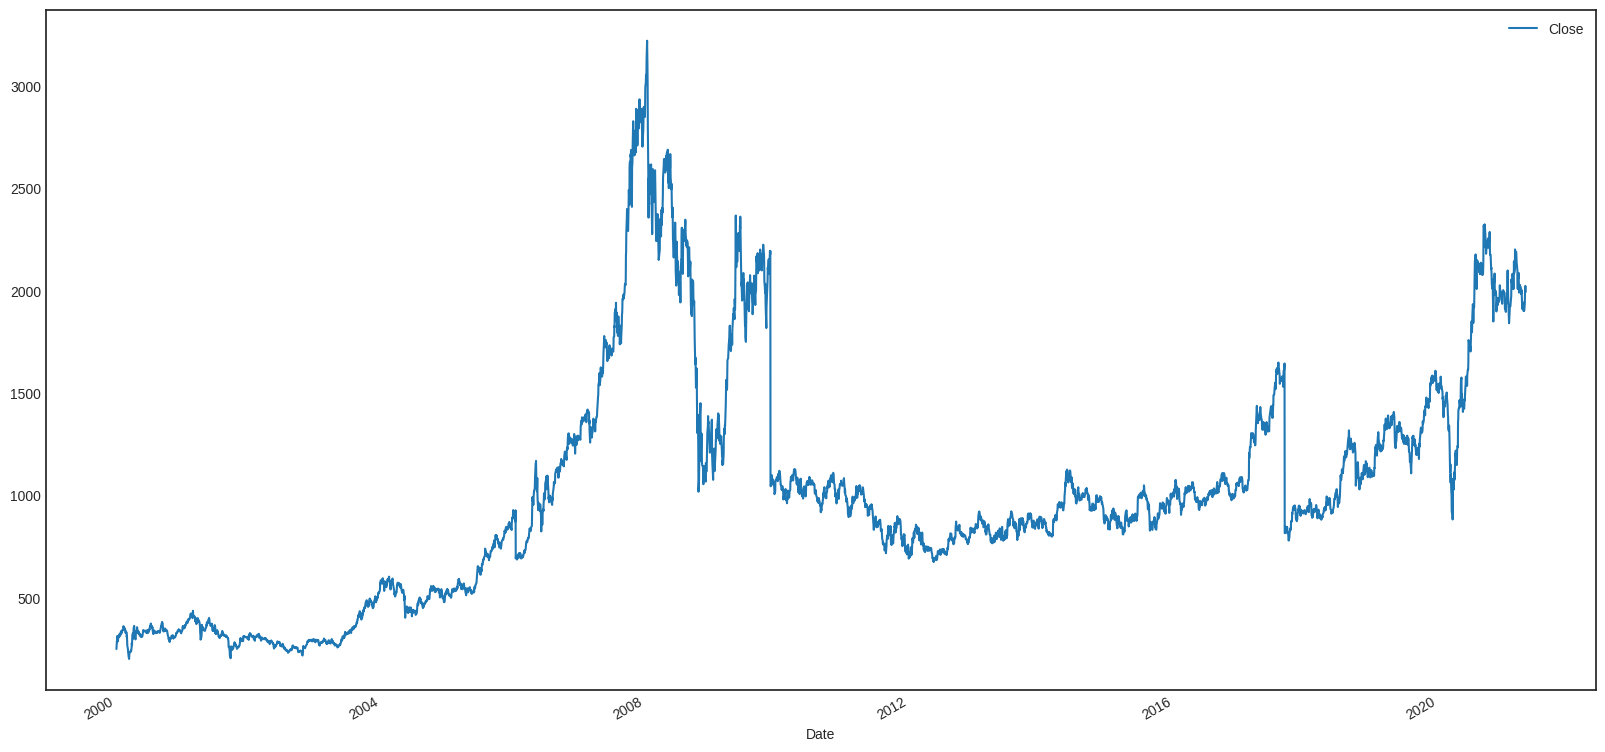

In [92]:
#Visually checking for stationarity
reliance_stationarity=reliance_analysis[['Close']]

reliance_stationarity.plot()

In [93]:
#Augmented Dickey Fuller Test
test_result=adfuller(reliance_stationarity['Close'])

#Ho: Data is non stationary
#H1: Data is stationary

def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(reliance_stationarity['Close'])

ADF Test Statistic : -1.849052109725118
p-value : 0.35639470126042105
#Lags Used : 20
Number of Observations Used : 5285
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


<Axes: xlabel='Date'>

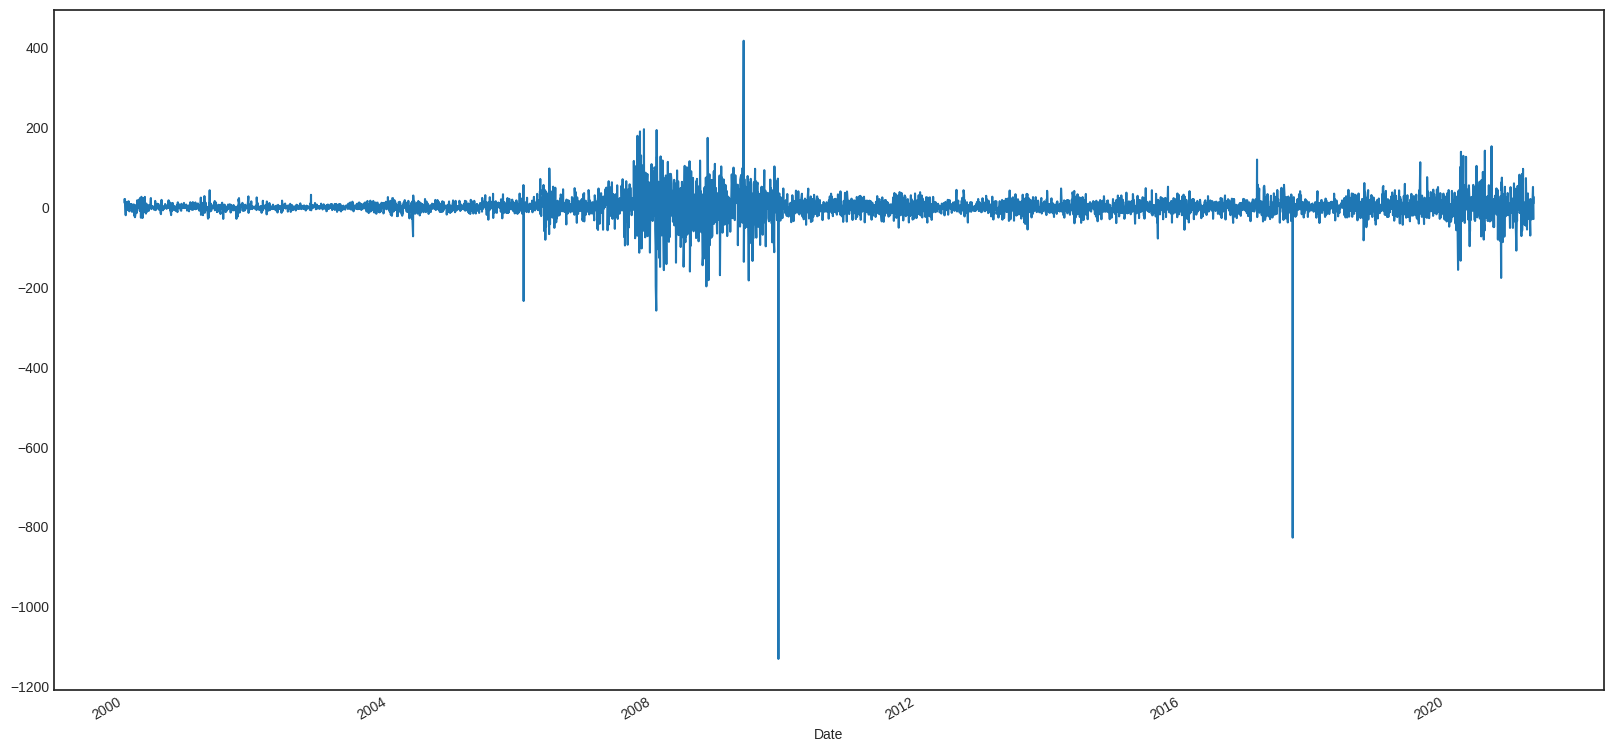

In [94]:
#Stationarity Conversion with shift()
reliance_stationarity['Close First Difference']=reliance_stationarity['Close']-reliance_stationarity['Close'].shift(1)
reliance_stationarity['Close First Difference'].plot()

# **Prediction Modeling**

In [30]:
train = reliance_lag[reliance_lag.Date < "2019"]
valid = reliance_lag[reliance_lag.Date >= "2019"]

In [57]:
exogenous_features = ['High_mean_lag3','High_mean_lag7', 'High_mean_lag30', 'High_std_lag3', 'High_std_lag7',
       'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7', 'Low_mean_lag30',
       'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30', 'Volume_mean_lag3',
       'Volume_mean_lag7', 'Volume_mean_lag30', 'Volume_std_lag3',
       'Volume_std_lag7', 'Volume_std_lag30', 'VWAP_mean_lag3',
       'VWAP_mean_lag7', 'VWAP_mean_lag30', 'VWAP_std_lag3', 'VWAP_std_lag7',
       'VWAP_std_lag30','Month', 'Week', 'Day', 'Day of week']

In [84]:
model = auto_arima(train.Close, exogenous=train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train.Close, exogenous=train[exogenous_features])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=46534.334, Time=6.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46575.276, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46571.295, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=46571.287, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46573.420, Time=0.09 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=46562.819, Time=2.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=46560.346, Time=7.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=46535.054, Time=8.58 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=46535.045, Time=9.43 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=46573.282, Time=1.52 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=46546.351, Time=2.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=46543.550, Time=6.05 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=46535.601, Time=7.89 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=46532.503, Time=1.69 sec
 ARIMA(1,1,2)(0,0,0

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [86]:
valid["Close","Forecast_ARIMAX"] = model.predict(n_periods=len(valid), exogenous=valid[exogenous_features])

<Axes: xlabel='Date'>

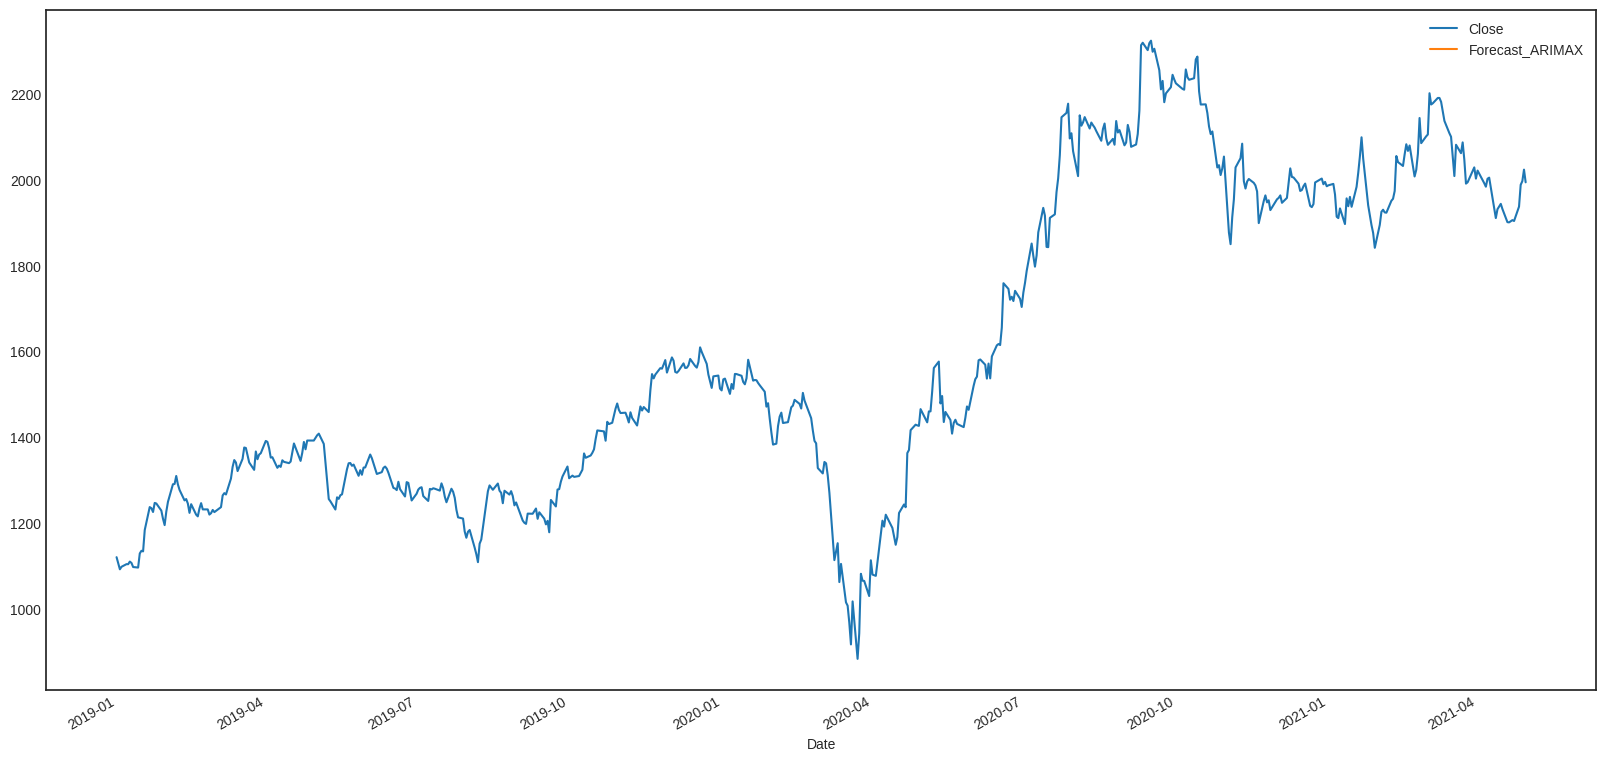

In [87]:
valid[["Close", "Forecast_ARIMAX"]].plot()

# **Fb Prophet**

In [43]:
### intiialize the Model
model=Prophet()

#Fitting the model and renaming the columns based on prophe requirements
model.fit(reliance_analysis[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"}))

#Making future dataframe for forecasting, we have given 365 days which can calculate VWAP till 2021
reliance_future=model.make_future_dataframe(periods=365)

#Checking the future dates
reliance_future.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/o5zfxpsx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/nw230dyt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76915', 'data', 'file=/tmp/tmpsin9xmlr/o5zfxpsx.json', 'init=/tmp/tmpsin9xmlr/nw230dyt.json', 'output', 'file=/tmp/tmpsin9xmlr/prophet_modelzvq8vtxx/prophet_model-20240805114738.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:47:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:47:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


ds
5666 2022-04-26
5667 2022-04-27
5668 2022-04-28
5669 2022-04-29
5670 2022-04-30

In [44]:
### Prediction of future values
reliance_prediction=model.predict(reliance_future)

reliance_prediction.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
5666 2022-04-26  2040.780870  1736.513952  2337.562131  1896.589527   
5667 2022-04-27  2041.338747  1743.537768  2354.035275  1895.710200   
5668 2022-04-28  2041.896624  1769.886946  2357.530196  1894.907857   
5669 2022-04-29  2042.454501  1743.895628  2344.824937  1894.922274   
5670 2022-04-30  2043.012378  1792.866827  2384.765834  1895.144900   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5666  2207.792604       -4.458114             -4.458114             -4.458114   
5667  2209.122692       -1.200831             -1.200831             -1.200831   
5668  2210.199074       -0.498419             -0.498419             -0.498419   
5669  2211.582888       -3.078010             -3.078010             -3.078010   
5670  2212.966702       35.504030             35.504030             35.504030   

         weekly  weekly_lower  weekly_upper    yearly  yearly_lower  \
5666  -3.673254     -3.673254     -3.673254 -0.784860     -0.784860   
5667  -1.245396     -1.245396     -1.245396  0.044566      0.044566   
5668  -1.355862     -1.355862     -1.355862  0.857443      0.857443   
5669  -4.731027     -4.731027     -4.731027  1.653017      1.653017   
5670  33.075048     33.075048     33.075048  2.428982      2.428982   

      yearly_upper  multiplicative_terms  multiplicative_terms_lower  \
5666     -0.784860                   0.0                         0.0   
5667      0.044566                   0.0                         0.0   
5668      0.857443                   0.0                         0.0   
5669      1.653017                   0.0                         0.0   
5670      2.428982                   0.0                         0.0   

      multiplicative_terms_upper         yhat  
5666                         0.0  2036.322757  
5667                         0.0  2040.137917  
5668                         0.0  2041.398205  
5669                         0.0  2039.376491  
5670                         0.0  2078.516408

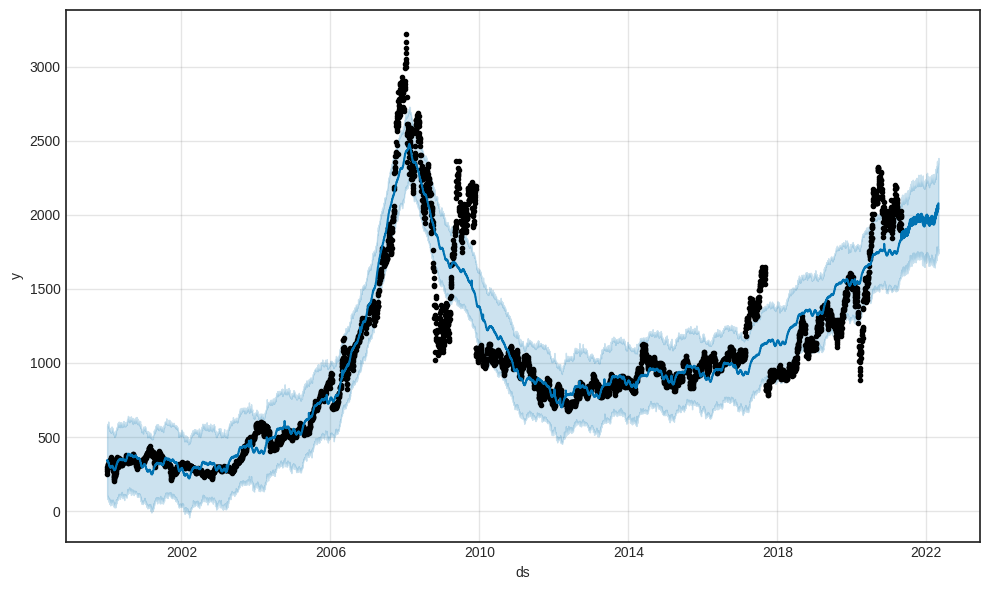

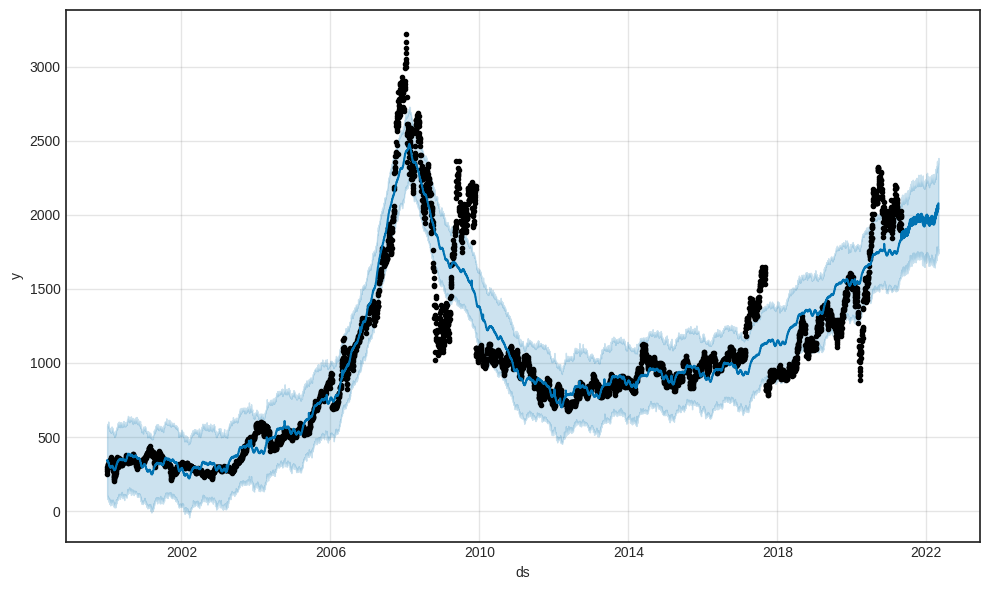

In [45]:
model.plot(reliance_prediction)

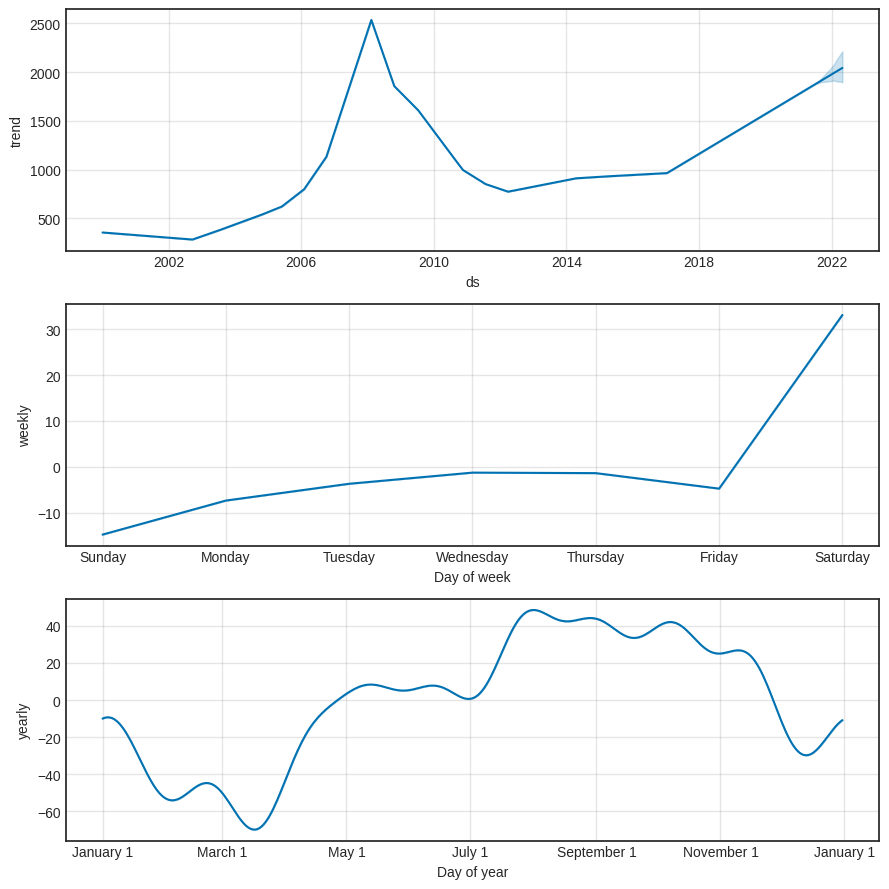

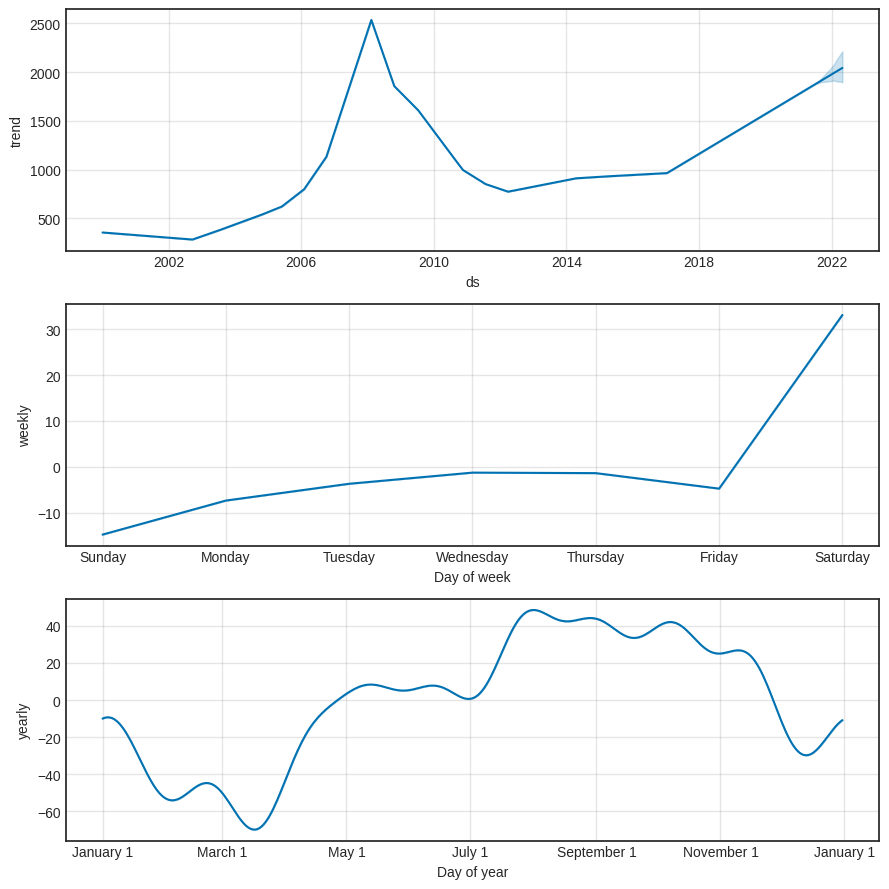

In [46]:
model.plot_components(reliance_prediction)

In [47]:
reliance_cv=cross_validation(model,initial='1095 days',period='180 days',horizon="365 days")

INFO:prophet:Making 36 forecasts with cutoffs between 2003-01-30 00:00:00 and 2020-04-30 00:00:00


  0%|          | 0/36 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/9lqsdh92.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/d_7v17cc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43469', 'data', 'file=/tmp/tmpsin9xmlr/9lqsdh92.json', 'init=/tmp/tmpsin9xmlr/d_7v17cc.json', 'output', 'file=/tmp/tmpsin9xmlr/prophet_modelauleugnh/prophet_model-20240805115311.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/t5lpdzui.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpsin9xmlr/ca7w9oql.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

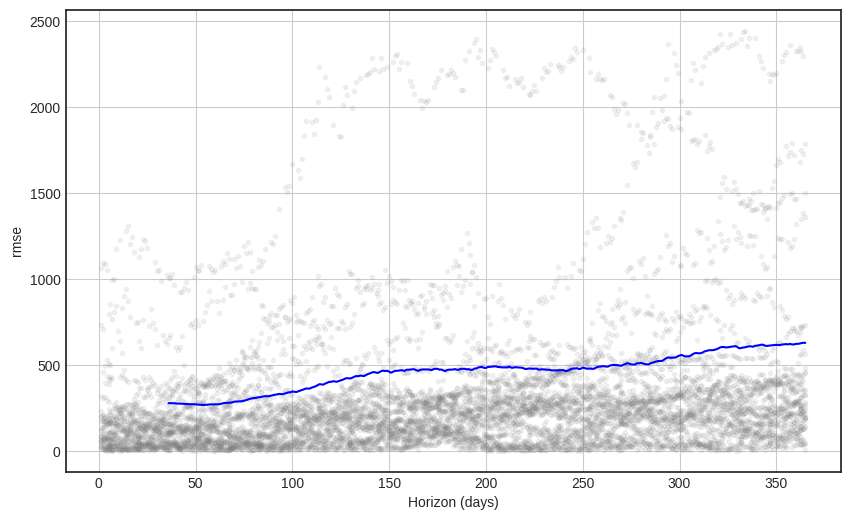

In [48]:
#Checking the parameters
reliance_performance=performance_metrics(reliance_cv)
reliance_performance.head()


#Plotting for root mean squared metric
fig=plot_cross_validation_metric(reliance_cv,metric='rmse')